<a href="https://colab.research.google.com/github/tmyeomans/COVID-19-Datathon/blob/master/Covid19Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alberta Innovates - COVID-19 Hackathon**
###**A Tale of Two Cities: 311 data in Edmonton and Calgary in Response to Covid-19**

# Introduction

Covid-19 has changed the world in many significant ways.  We have added social distancing into our daily lexicon, and our collective behaviour has changed as a result.  This project has looked at 311 reports in Calgary and Edmonton relating to Covid-19 social distancing to see how events and communication has impacted citizen behaviour, and to see how this differs in two Alberta cities with the same provincial messaging.

#Data Sources and Considerations

Both Calgary and Edmonton have an open source data portal with 311 requests available.  How each city records these requests varies drastically.  


The City of Calgary has placed all of the Covid-19 social distancing related requests into the service name field of "Bylaw - Disturbance and Behavioural Concerns", lumping the Covid-19 related reports into a pre-existing category with other unrelated concerns.  Without a publically facing indicator that it is Covid-19 related, the 2020 data must be compared to a historical baseline to understand what may be pandemic related.


In contrast, the City of Edmonton has taken the opposite approach.  Under the serivce category field they have numerous categories labeled with "COVID".  Some obviously fit the behaviour criteria we are looking for such as "COVID-Physical Distancing Complaint", while others such as "COVID - Animal Service Changes" are more ambigious.  As such, the categories deemed to be related to citizen behaviour concerns were grouped together for analysis. The other consideration with the Edmonton dataset is that the COVID related reports begin on March 30 for the categories that we have determined fit a social distancing theme.  Given that the Alberta Chief Medical Officer put in a Public Health Order on March 27, 2020 requiring that non-essential businesses close and that people stay a minimum of 2 meters away from one another, we could expect the Covid related 311 requests to start around that time.  Earlier requests may be included in other pre-existing categories as with the Calgary data, but that was not explored for this project.


# Import/Install Required Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install sodapy
from sodapy import Socrata
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#City of Calgary Covid-19 Related 311 Requests

![picture](https://drive.google.com/uc?id=1HVa6ZI7nx-RE9p30G1feThiQIbvb-7_s)

## Data Acquisition: Calgary 311 Dataset

Link to the city of Calgary's open data API to access the 311 Service Requests dataset. Load the data related to "Bylaw - Disturbance and Behavioural Concerns". Write to a pandas dataframe, and preview the data.

In [0]:
# Use sodapy to use the city of Calgary api and access the 311 open dataset:
client = Socrata("data.calgary.ca", None)

# 20000 results, returned as JSON from API / converted to Python list of dictionaries by sodapy:
results = client.get("iahh-g8bj", service_name= "Bylaw - Disturbance and Behavioural Concerns", limit=20000)

# Convert results to a pandas DataFrame, results_df:
results_df = pd.DataFrame.from_records(results)

# Peruse the data:
print(results_df.info())
print(len(results_df.index))
print(results_df['requested_date'].min())
print(results_df['requested_date'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   service_request_id  20000 non-null  object
 1   requested_date      20000 non-null  object
 2   updated_date        19998 non-null  object
 3   status_description  20000 non-null  object
 4   source              20000 non-null  object
 5   service_name        20000 non-null  object
 6   agency_responsible  20000 non-null  object
 7   comm_code           19991 non-null  object
 8   comm_name           19991 non-null  object
 9   location_type       20000 non-null  object
 10  longitude           19991 non-null  object
 11  latitude            19991 non-null  object
 12  point               19991 non-null  object
 13  closed_date         19856 non-null  object
dtypes: object(14)
memory usage: 2.1+ MB
None
20000
2012-01-01T00:26:17.000
2020-05-07T00:00:00.000


## Dates & Times, Calgary 311 Call Counts

Since we want to analyze the historical activity of the data, we will transform the 'requested_date' information to a datetime data type and set it as the DataFrame index so that we can more easily plot the dates that the 311 disturbance and behavioural concern calls occurred. We also want to count and capture the daily number of 311 calls related to "Bylaw - Disturbance and Behavioural Concerns" that were recieved by the city for the entire dataset.

In [0]:
# Transform the 'requested_date' data into a datetime data type
results_df['requested_date'] = pd.to_datetime(results_df['requested_date'], format="%Y-%m-%d %H:%M:%S")

# df.sort_values() by date
sort_results_df = results_df.sort_values(['requested_date'])

# Create a new dataframe to view just the 'requested_date' and 'service_name'
# (with the idea that we will plot the service_name count by date over time)
df_plot = sort_results_df[['requested_date', 'service_name']]

# Set the dataframe index to a datetime index
df_plot = df_plot.set_index('requested_date')
print(df_plot.head())

# Count the number of service requests per day
daily_reports = df_plot.resample('D').count()

# change the column name to something that makes more sense
daily_reports.rename(columns={'service_name':'daily_service_req'}, inplace = True)
print (daily_reports.head())

                                                     service_name
requested_date                                                   
2012-01-01 00:26:17  Bylaw - Disturbance and Behavioural Concerns
2012-01-01 11:24:01  Bylaw - Disturbance and Behavioural Concerns
2012-01-01 23:33:30  Bylaw - Disturbance and Behavioural Concerns
2012-01-02 01:32:19  Bylaw - Disturbance and Behavioural Concerns
2012-01-02 07:20:07  Bylaw - Disturbance and Behavioural Concerns
                daily_service_req
requested_date                   
2012-01-01                      3
2012-01-02                      8
2012-01-03                     10
2012-01-04                      7
2012-01-05                      6


## Plot Calgary 311 Disturbance & Behavioural Concerns Call Counts Over Time

Daily 311 call count for calls related to "Bylaw - Disturbance and Behavioural Concerns" that were recieved by the city of Calgary for the entire dataset.

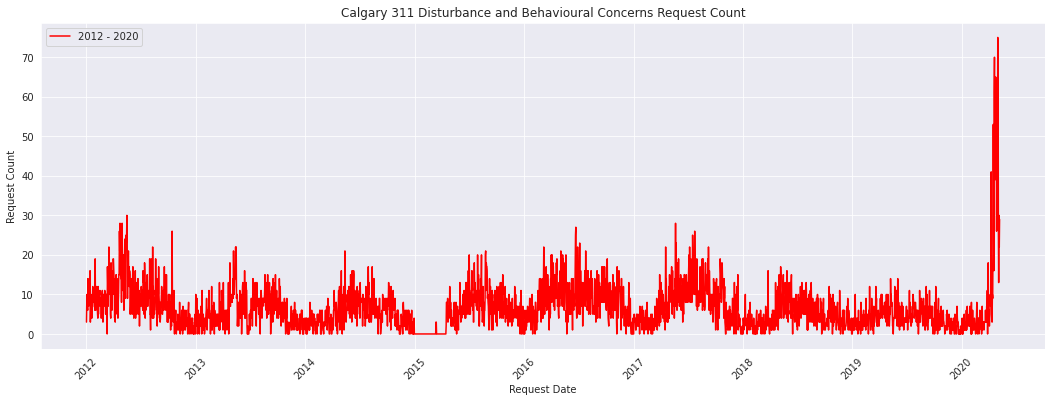

In [0]:
sns.set_style("darkgrid")

fig, ax = plt.subplots()

# Add the time-series for daily_reports to the plot
ax.plot(daily_reports.index, daily_reports["daily_service_req"], label='2012 - 2020', c='r')

# Set the x-axis label
ax.set_xlabel('Request Date')
plt.xticks(rotation=45)

# Set the y-axis label
ax.set_ylabel('Request Count')

# Add the title
ax.set_title("Calgary 311 Disturbance and Behavioural Concerns Request Count")

# Set figure dimensions
fig.set_size_inches([18, 6])

# Display legend
ax.legend()

# Display the plot
plt.show()

Plotting the historic 311 calls related to "Disturbance and Behavioural Concerns Requests" over time provided the first indicator that this dataset would provide interesting insights.  You can see from the plot that there is an annual pattern to 311 requests of this nature, likely heavily influenced by weather.  You can see the dramatic change in the plot in spring 2020.

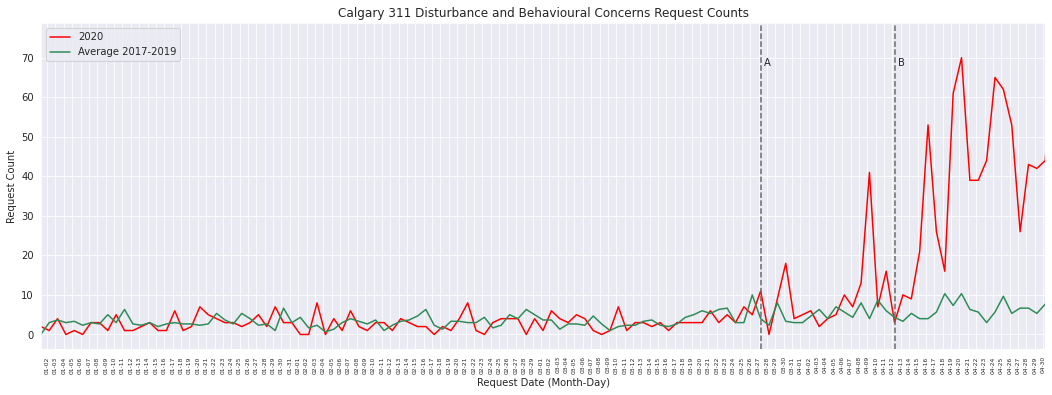

In [0]:
# Calgary - Plot 2020 versus 2017-2019

daily_reports['axisdate'] = daily_reports.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d'))
daily_reports['year'] = daily_reports.index.to_series().apply(lambda x: x.strftime('%Y'))
daily_reports['month'] = daily_reports.index.to_series().apply(lambda x: x.strftime('%m'))
daily_reports['day'] = daily_reports.index.to_series().apply(lambda x: x.strftime('%d'))
# Strip off month day data, and at to df column
daily_reports['monthday'] = daily_reports.index.to_series().apply(lambda x: x.strftime('%m-%d'))
# print (daily_reports.head())

# Make dataframe of 2020 data only
twenty_df = daily_reports.loc['2020-1-1':'2020-12-31']
# print(twenty_df)

# Make dataframe of date range 2017-2019
history_df = daily_reports.loc['2017-1-1':'2019-12-31']
# print(history_df)

# Plot twenty_df and history_df with month day info on x-axis (merge month and day together)

# Generate daily average counts for the years 2017-2019
avgdailyall = history_df.groupby([history_df.month, history_df.day]).mean()
# print(avgdailyall.head())

# Reset index to preserve grouping and prep for plot
avgdailyall = avgdailyall.reset_index()
# print(avgdailyall)

# Recompile date for datetime index
avgdailyall['mdstring'] = '1903' + '-' + avgdailyall['month'].map(str) + '-' + avgdailyall['day'].map(str)
# print(avgdailyall)

# Set the dataframe index to a datetime index
avgdailyall = avgdailyall.set_index('mdstring')
# print(avgdailyall.head())


# Strip off month day data, and at to df column
avgdailyall['monthday'] = avgdailyall['month'].map(str) + '-' + avgdailyall['day'].map(str)
# print(avgdailyall.head())

# Plot 2020 data with average 2017-2019 data
sns.set_style("darkgrid")
fig, ax = plt.subplots()

ax.plot(twenty_df['monthday'], twenty_df["daily_service_req"], label='2020', c='r')
ax.plot(avgdailyall['monthday'], avgdailyall['daily_service_req'], label= 'Average 2017-2019', c='seagreen')

# Set the x-axis label
ax.set_xlabel('Request Date (Month-Day)')

# Layout
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 1))
plt.xticks(rotation=90, fontsize=6)

# Set the y-axis label
ax.set_ylabel('Request Count')

# Add the title
ax.set_title("Calgary 311 Disturbance and Behavioural Concerns Request Counts")

# Set figure dimensions
fig.set_size_inches([18, 6])

# Set plot width
ax.set_xlim(0, 120)

#vline
ax.axvline(x=86, linestyle='--', c='dimgrey')
ax.axvline(x=102, linestyle='--', c='dimgrey')

# Or you could label the vline like this:
plt.text(86.4,68,'A',rotation=0)
plt.text(102.4,68,'B',rotation=0)

# Display the legend
ax.legend()

# Display the plot
plt.show()


The 2020 data to date was plotted compared to the historic average from 2017 to 2019 to visualize how far it deviated from the baseline level of complaints.  Historic data exists as far back as 2012, but the team decided to use only the most recent 3 years as the demographics of the city and neighbourhoods are assumed to be more similar to 2020 than in years further past.  

On the plot you can see that until late March, 2020 was tracking well with historical data.  The line indicated with an "A" on the graph is March 27th, when the provincial wide Chief Medical Officer Health Order relating to social distancing measures went into effect.

The other line indicated with a "B" represents when Alberta Health Services confirmed they were invesitgating worker safety at the Cargill meat plant in High River.  Many plant workers commute from Calgary to High River.  News organizations starting picking up the story around April 12th. As of the time of writing, the Cargill outbreak represents the largest outbreak of Covid-19 in North America.   

![Picture](https://drive.google.com/uc?id=1hQ0a0gSXR1UWoVYIM_RZF9biVcvxBQqn)

[Calgary 311 Bylaw - Disturbance and Behavioural Concerns Reported Jan 01 - April 30, 2020 compared to baseline complaints (2017-2019) - Interactive map](https://calgary311-socialdistancingdata-2020-abovebaseline.netlify.app/#12/51.0251/-114.0707)

The map above shows the 311 reports for "Disturbance and Behavioural Concerns for all of 2020 compared to the baseline average over the past 3 years (2017 - 2019)". High values exist throughout the map and are prominent in popular parks such as Bowness Park and Glenmore Park.  Notable suburban communities with high reported values include Coventry Hills, Woodbine, Signal Hill, West Springs and New Brighton.

# City of Edmonton Covid-19 Related 311 Requests

![picture](https://drive.google.com/uc?id=1rTrQuotZsPklvRUiwIB9irjNpBBe6U2m)

## Data Acquisition: Edmonton 311 Dataset

Link to the city of Edmonton's open data API to access the 311 Service Requests dataset. Load the data, write to a pandas dataframe, and preview the data.

In [0]:
# Edmonton
# Use sodapy to use the city of Calgary api and access the 311 open dataset:
client = Socrata("data.edmonton.ca", None)

# 90000 results, returned as JSON from API / converted to Python list of dictionaries by sodapy:
resultsE = client.get("q7ua-agfg", limit=90000)

# Convert results to a pandas DataFrame, resultsE_df:
resultsE_df = pd.DataFrame.from_records(resultsE)


# Transform the 'requested_date' data into a datetime data type
resultsE_df['date_created'] = pd.to_datetime(resultsE_df['date_created'], format="%Y-%m-%d %H:%M:%S")

# Peruse the data
print(resultsE_df.info())
print(len(resultsE_df.index))
print(resultsE_df['date_created'].min())
print(resultsE_df['date_created'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   row_id                            90000 non-null  object        
 1   date_created                      90000 non-null  datetime64[ns]
 2   year                              90000 non-null  object        
 3   month_number                      90000 non-null  object        
 4   month                             90000 non-null  object        
 5   request_status                    90000 non-null  object        
 6   service_category                  90000 non-null  object        
 7   service_description               90000 non-null  object        
 8   interaction_channel               90000 non-null  object        
 9   service_area                      90000 non-null  object        
 10  referral_type                     90000 non-nu

## Dates & Times, Edmonton 311 Call Counts

Filter and group "COVID" categories deemed to be related to citizen behaviour concerns. Transform the 'date_created' information to a datetime data type and set it as the DataFrame index in order to plot the dates that the 311 calls occurred. Capture the daily count for the number of calls that were recieved by the city for the entire dataset.

In [0]:
# df.sort_values() by date
resultsE_df = resultsE_df.sort_values(['date_created'])

# Here str.contain() returns True if text string "COVID" is found, and False if it is not found
resultsE_df['CovidAll'] = resultsE_df['service_description'].str.contains('COVID')

Covid_df = resultsE_df[resultsE_df.CovidAll == True]
#print(Covid_df)

# ServDesc = Covid_df['service_description']
# print(ServDesc)

# Discover unique service description entries with the word "COVID" in them
unique_values = pd.unique(Covid_df['service_description'])
#print(unique_values)

# Target entries that fit the category Disturbance and Behavioural Concerns to compare to Calgary dataset
# 'COVID - Physical Distancing Complaint'
# 'COVID - Mass Gathering Unacceptable'
# 'COVID - Open Business Unacceptable'
# 'COVID - Worksite Conditions and Safety'
# 'COVID - Garage/Yard Sale Restriction'

# Filter to target "COVID" entries
ECovid_Subset = Covid_df[(Covid_df.service_description == 'COVID - Physical Distancing Complaint') |
                         (Covid_df.service_description == 'COVID - Mass Gathering Unacceptable') |
                         (Covid_df.service_description == 'COVID - Open Business Unacceptable') |
                         (Covid_df.service_description == 'COVID - Worksite Conditions and Safety') |
                         (Covid_df.service_description == 'COVID - Garage/Yard Sale Restriction')]
# print(ECovid_Subset.head())

# Filter check
# unique_values2 = pd.unique(ECovid_Subset['service_description'])
# print(unique_values2)

# Date check
# print(ECovid_Subset.date_created.min())

# Create a new dataframe to view just the 'date_created' and 'service_category' for the plot count over time
df_plotE = ECovid_Subset[['date_created', 'service_description']]
print(df_plotE.head())

# Set the plot dataframe index to a datetime index
df_plotE = df_plotE.set_index('date_created')

# Make dataframe date range to end of Apri;
df_plotE = df_plotE.loc['2020-3-30':'2020-4-30']
# print(df_plotE.head())

# Count the number of service requests per day
daily_reportsE = df_plotE.resample('D').count()
# print(daily_reportsE)

# Change the column name to something that makes more sense
daily_reportsE.rename(columns={'service_description':'daily_service_req_Ed'}, inplace = True)
#print(daily_reportsE)

             date_created                    service_description
89306 2020-04-01 11:23:38     COVID - Open Business Unacceptable
88813 2020-04-01 13:20:37  COVID - Physical Distancing Complaint
88702 2020-04-01 13:40:43     COVID - Open Business Unacceptable
88384 2020-04-01 14:59:02  COVID - Physical Distancing Complaint
88069 2020-04-01 16:35:41     COVID - Open Business Unacceptable


## Plot Edmonton 311 Disturbance & Behavioural 'Type' Concerns Call Counts Over Time

Daily 311 call count for calls related to Covid-19 disturbance and behavioural "type" concerns that were recieved by the city of Edmonton for the entire dataset.

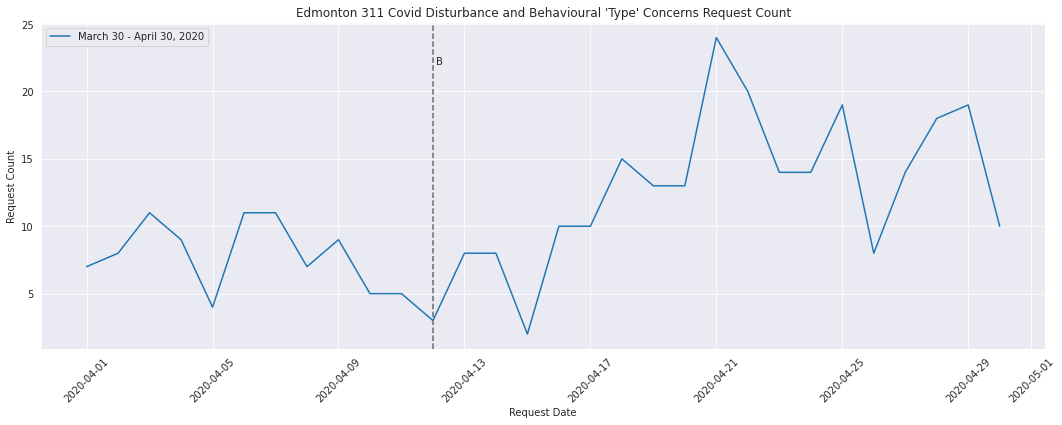

In [0]:
# Plot the data
# import matplotlib.pyplot as plt
sns.set_style("darkgrid")
fig, ax = plt.subplots()

# Add the time-series for daily_reports to the plot
ax.plot(daily_reportsE.index, daily_reportsE["daily_service_req_Ed"], label= 'March 30 - April 30, 2020')

# Set the x-axis label
ax.set_xlabel('Request Date')
plt.xticks(rotation=45)

# Set the y-axis label
ax.set_ylabel('Request Count')

# Set figure dimensions
fig.set_size_inches([18, 6])

# Add the title
ax.set_title("Edmonton 311 Covid Disturbance and Behavioural 'Type' Concerns Request Count")

#vline
ax.axvline(x=pd.Timestamp('2020-04-12'), linestyle='--', c='dimgrey')
# plt.axvline(dt.datetime(2012, 9, 21))
#plt.axvline(pd.Timestamp('2020-04-12'),color='r')

# Label the vline like this:
plt.text(pd.Timestamp('2020-04-12 02:00:00'),22,'B',rotation=0)

# Display the legend
ax.legend(loc='upper left')

# Display the plot
plt.show()

As mentioned previously, Edmonton has specific categories for Covid-19 related requests.  The above plot shows the trend of those categories that relate to social distancing, including the categories of "Physical Distancing Complaint", "Mass Gathering Unacceptable", "Open Business Unacceptable", "Worksite Conditions and Safety" and "Garage/Yard Sale Restriction".  We again plotted 'B', the Cargill outbreak date, after which a gradual increase in the number of complaints occurs, though these counts are much lower than those over the same time period in Calgary. There appears to be other factors that correlate to increased request counts. We took an initial look at some of these factors, and increases due to days with nicer weather seem apparent, as well as increases those on weekends. This would apply to both cities. A more in-depth invstigation into these correlations is out of scope for this project but warrants further analysis at a later time.

![Picture](https://drive.google.com/uc?id=1KdoNjKBPLcxwH5m2uqTep0kneidCOsRW)

[Edmonton 311 COVID social distancing related requests March 30 - April 30, 2020 - Interactive map](https://edmonton311-socialdistancingdata-mar30-apr30.netlify.app/)



Above is a map showing the distribution of the requests by community over the same time period.  Reports per community are typically in the 0 - 2 range, with the communities of Downtown, Oliver and Fraser being notable exceptions with 10 requests each. 

# Calgary & Edmonton Comparison

Calgary & Edmonton Comparison - March 30 - April 30, 2020

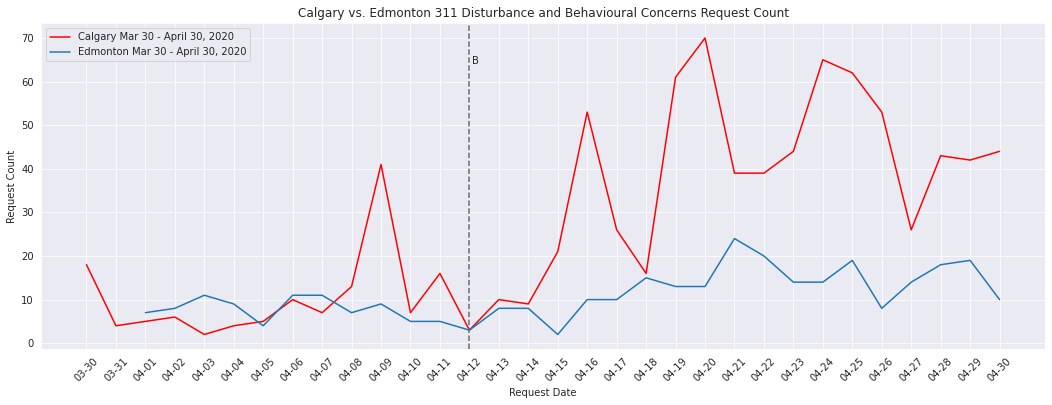

In [0]:
# Plot April for both Calgary and Edmonton

# Set up for March 30th to April 30 date range for Calgary data
daily_reportsE['axisdate'] = daily_reportsE.index.to_series().apply(lambda x: x.strftime('%Y-%m-%d'))
daily_reportsE['year'] = daily_reportsE.index.to_series().apply(lambda x: x.strftime('%Y'))
daily_reportsE['month'] = daily_reportsE.index.to_series().apply(lambda x: x.strftime('%m'))
daily_reportsE['day'] = daily_reportsE.index.to_series().apply(lambda x: x.strftime('%d'))
daily_reportsE['monthday'] = daily_reportsE.index.to_series().apply(lambda x: x.strftime('%m-%d'))
# print(daily_reportsE.head())

# Clip Calgary date range to be March 30th to April 30
daily_reports = daily_reports.loc['2020-3-30':'2020-4-30']


# Plot the data
# import matplotlib.pyplot as plt
sns.set_style("darkgrid")
fig, ax = plt.subplots()

# Add the time-series for daily_reports(E) to the plot
ax.plot(daily_reports['monthday'], daily_reports["daily_service_req"], label= 'Calgary Mar 30 - April 30, 2020', c='r')
ax.plot(daily_reportsE['monthday'], daily_reportsE["daily_service_req_Ed"], label= 'Edmonton Mar 30 - April 30, 2020')


# Set the x-axis label
ax.set_xlabel('Request Date')
plt.xticks(rotation=45)

# Set the y-axis label
ax.set_ylabel('Request Count')

# Set figure dimensions
fig.set_size_inches([18, 6])

# Add the title
ax.set_title("Calgary vs. Edmonton 311 Disturbance and Behavioural Concerns Request Count")

#vline
ax.axvline(x=13, linestyle='--', c='dimgrey')

# Or you could label the vline like this:
plt.text(13.1,64,'B',rotation=0)


# Display the legend
ax.legend(loc='upper left')

# Display the plot
plt.show()

The plot above includes the March 30 to April 30, 2020 311 data for both cities.  Although the Calgary data is not categorized as Covid-19 specific behavioural concerns, the marked increase in counts from the baseline shown earlier in the report implies that the abnormally high counts are due to Covid-19 related requests. The line "B" as before indicates when news of the Cargill outbreak started to emerge.  While the Edmonton plot increases slightly over the rest of the month, the Calgary plot increases dramatically.

![Picture](https://drive.google.com/uc?id=1Ai1bXQ0EKdbElO7Fl5-Sar8mOKaWQu6w)
[Calgary 311 Bylaw - Disturbance and Behavioural Concerns requests March 30 - April 30, 2020 - Interactive map](https://calgary311-socialdistancingdata-abovebaseline-mar30-apr30.netlify.app/)
![Picture](https://drive.google.com/uc?id=1KdoNjKBPLcxwH5m2uqTep0kneidCOsRW)
[Edmonton 311 COVID social distancing related requests March 30 - April 30, 2020 - Interactive map](https://edmonton311-socialdistancingdata-mar30-apr30.netlify.app/)



The Calgary data over the same month in both maps is markedly higher than the Edmonton data.  To bring the Calgary data more in line with the Edmonton data, the baseline average number of "Disturbance and Behavioural Concerns" requests for the past three years (2017 - 2019) was calculated per community, and then an average request per year was calculated.  This was then subtracted from the 2020 values for the same time period.  The same colour symbology was used for both maps.

#Conclusions

311 requests provide information on two groups.  The people that are making the request, and the people that the request is about.  Messaging from different levels of government can influence the behaviour of citizen action.  New social norms and bylaws can reinforce this.

Reviewing the temporal and spatial data related to Covid-19 could help city departments decide where and when to delegate resources such as increased signage related to social distancing or allocating additional bylaw officers to certain areas.  

Events at both the local, and provincial scale can significantly impact citizen behaviour.  After the provincial health order came into effect, both cities had an increase in complaints relating to social distancing.  Locally we can see the effects due to events like the Cargill outbreak. The Cargill outbreak concides with an increase in requests in both cities. However, a more significant increase was observed in the Calgary requests, likely due to it's proximity to the plant. 

Reviewing multiple cities together and piecing together a timeline of municipal, provincial and federal messaging and measures could help the government decide what methods worked, and which fell short.  The greatest issue in comparative work between the cities is the differences in the classifying and reporting of data.  Future considerations on data management and coordination for national emergencies would go a long way in providing insight.

#Future Work

1. Incorporating demographic information for communities
2. Assessing amenities per community that may help to explain the distribution of calls
3. Continue monitoring trends
4. Set-up map models for automated updates
5. Investigate correlations with weather, weekends, and holidays



By Tanya Yeomans & Tim Mack